In [75]:
from ly.musicxml import create_musicxml as MusicXML
import numpy as np
import soundfile as sf
import sys
import os
import datetime
from scipy import signal
import matplotlib.pyplot as plt
import IPython.display as ipd
import statistics as stats
from librosa import beat, display, feature, onset
from functools import reduce

# Allows me to import my modules
sys.path.append('./modules')

# The python definition of f(x) for problem 1.
from audio_utils import *

In [40]:
# MusicXML for the overall score structure and 10 drum kit classes. (Musescore compatible)

body = '''
<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE score-partwise PUBLIC "-//Recordare//DTD MusicXML 2.0 Partwise//EN" "http://www.musicxml.org/dtds/partwise.dtd">
<score-partwise version="3.0">
    <movement-title>{}</movement-title>
    <identification>
        <encoding>
            <software>
                Dan's drum kit auto-transcriptor
            </software>
            <encoding-date>{}</encoding-date>
        </encoding>
    </identification>
    <part-list>
    {}
    </part-list>
    <part id="P1">
    {}
    </part>
</score-partwise>
'''

measure_attributes = '''
<attributes>
    <divisions>2</divisions>
    <key>
        <fifths>0</fifths>
    </key>
    <time>
        <beats>4</beats>
        <beat-type>4</beat-type>
    </time>
    <clef>
        <sign>percussion</sign>
        <line>2</line>
    </clef>
</attributes>
'''

drumkit_part_list = '''
<score-part id="P1">
    <part-name>Drum kit</part-name>
    <score-instrument id="P1-I36">
        <instrument-name>Bass drum</instrument-name>
    </score-instrument>
    <score-instrument id="P1-I39">
        <instrument-name>Snare</instrument-name>
    </score-instrument>
    <score-instrument id="P1-I42">
        <instrument-name>Low tom</instrument-name>
    </score-instrument>
    <score-instrument id="P1-I43">
        <instrument-name>Closed hi-hat</instrument-name>
    </score-instrument>
    <score-instrument id="P1-I47">
        <instrument-name>Open hi-hat</instrument-name>
    </score-instrument>
    <score-instrument id="P1-I48">
        <instrument-name>Mid tom</instrument-name>
    </score-instrument>
    <score-instrument id="P1-I50">
        <instrument-name>Crash cymbal</instrument-name>
    </score-instrument>
    <score-instrument id="P1-I51">
        <instrument-name>High tom</instrument-name>
    </score-instrument>
    <score-instrument id="P1-I52">
        <instrument-name>Ride cymbal</instrument-name>
    </score-instrument>
    <score-instrument id="P1-I54">
        <instrument-name>Ride bell</instrument-name>
    </score-instrument>

    <midi-device port="1"></midi-device>

    <midi-instrument id="P1-I36">
        <midi-channel>10</midi-channel>
        <midi-program>1</midi-program>
        <midi-unpitched>36</midi-unpitched>
    </midi-instrument>
    <midi-instrument id="P1-I39">
        <midi-channel>10</midi-channel>
        <midi-program>1</midi-program>
        <midi-unpitched>39</midi-unpitched>
    </midi-instrument>
    <midi-instrument id="P1-I42">
        <midi-channel>10</midi-channel>
        <midi-program>1</midi-program>
        <midi-unpitched>42</midi-unpitched>
    </midi-instrument>
    <midi-instrument id="P1-I43">
        <midi-channel>10</midi-channel>
        <midi-program>1</midi-program>
        <midi-unpitched>43</midi-unpitched>
    </midi-instrument>
    <midi-instrument id="P1-I47">
        <midi-channel>10</midi-channel>
        <midi-program>1</midi-program>
        <midi-unpitched>47</midi-unpitched>
    </midi-instrument>
    <midi-instrument id="P1-I48">
        <midi-channel>10</midi-channel>
        <midi-program>1</midi-program>
        <midi-unpitched>48</midi-unpitched>
    </midi-instrument>
    <midi-instrument id="P1-I50">
        <midi-channel>10</midi-channel>
        <midi-program>1</midi-program>
        <midi-unpitched>50</midi-unpitched>
    </midi-instrument>
    <midi-instrument id="P1-I51">
        <midi-channel>10</midi-channel>
        <midi-program>1</midi-program>
        <midi-unpitched>51</midi-unpitched>
    </midi-instrument>
    <midi-instrument id="P1-I52">
        <midi-channel>10</midi-channel>
        <midi-program>1</midi-program>
        <midi-unpitched>52</midi-unpitched>
    </midi-instrument>
    <midi-instrument id="P1-I54">
        <midi-channel>10</midi-channel>
        <midi-program>1</midi-program>
        <midi-unpitched>54</midi-unpitched>
    </midi-instrument>
</score-part>
'''

drum_notes = ["bass_drum", "snare_drum", "low_tom", "mid_tom", "high_tom"]
cymbal_notes = ["crash", "hi_hat", "hi_hat_open", "ride", "ride_bell"]

instruments = {
    "bass_drum": '''
    <note>
        <unpitched>
            <display-step>F</display-step>
            <display-octave>4</display-octave>
        </unpitched>
        <duration>1</duration>
        <instrument id="P1-I36"/>
        <voice>2</voice>
        <type>eighth</type>
        <stem>up</stem>
    </note>
    ''',
    "snare_drum": '''
    <note>
        <unpitched>
            <display-step>C</display-step>
            <display-octave>5</display-octave>
        </unpitched>
        <duration>1</duration>
        <instrument id="P1-I39"/>
        <voice>2</voice>
        <type>eighth</type>
        <stem>down</stem>
    </note>
    ''',
    "low_tom": '''
    <note>
        <unpitched>
            <display-step>A</display-step>
            <display-octave>4</display-octave>
        </unpitched>
        <duration>1</duration>
        <instrument id="P1-I42"/>
        <voice>2</voice>
        <type>eighth</type>
        <stem>up</stem>
    </note>
    ''',
    "mid_tom": '''
    <note>
        <unpitched>
            <display-step>D</display-step>
            <display-octave>5</display-octave>
        </unpitched>
        <duration>1</duration>
        <instrument id="P1-I48"/>
        <voice>2</voice>
        <type>eighth</type>
        <stem>up</stem>
    </note>
    ''',
    "high_tom": '''
    <note>
        <unpitched>
            <display-step>E</display-step>
            <display-octave>5</display-octave>
        </unpitched>
        <duration>1</duration>
        <instrument id="P1-I49"/>
        <voice>2</voice>
        <type>eighth</type>
        <stem>up</stem>
    </note>
    ''',
    "hi_hat": '''
    <note>
        <unpitched>
            <display-step>F</display-step>
            <display-octave>5</display-octave>
        </unpitched>
        <duration>1</duration>
        <instrument id="P1-I43"/>
        <voice>1</voice>
        <type>eighth</type>
        <stem>up</stem>
        <notehead>x</notehead>
    </note>
    ''',
    "hi_hat_open": '''
    <note>
        <unpitched>
            <display-step>F</display-step>
            <display-octave>5</display-octave>
        </unpitched>
        <duration>1</duration>
        <instrument id="P1-I47"/>
        <voice>1</voice>
        <type>eighth</type>
        <stem>up</stem>
        <notehead>circle-x</notehead>
    </note>
    ''',
    "ride": '''
    <note>
        <unpitched>
            <display-step>G</display-step>
            <display-octave>5</display-octave>
        </unpitched>
        <duration>1</duration>
        <instrument id="P1-I52"/>
        <voice>1</voice>
        <type>eighth</type>
        <stem>up</stem>
        <notehead>x</notehead>
    </note>
    ''',
    "ride_bell": '''
    <note>
        <unpitched>
            <display-step>G</display-step>
            <display-octave>5</display-octave>
        </unpitched>
        <duration>1</duration>
        <instrument id="P1-I54"/>
        <voice>1</voice>
        <type>eighth</type>
        <stem>up</stem>
        <notehead>diamond</notehead>
    </note>
    ''',
    "crash": '''
    <note>
        <unpitched>
            <display-step>A</display-step>
            <display-octave>5</display-octave>
        </unpitched>
        <duration>2</duration>
        <instrument id="P1-I50"/>
        <voice>1</voice>
        <type>quarter</type>
        <stem>up</stem>
        <notehead>x</notehead>
    </note>
    '''
}

backup = '''
<backup>
    <duration>8</duration>
</backup>
'''

end_line = '''
<barline location="right">
    <bar-style>light-heavy</bar-style>
</barline>
'''

In [2]:
beat_dir = os.path.join(os.getcwd(), "audio_data", "raw_data", "drum_beats")
beats = []
for file in os.listdir(beat_dir):
    filepath = os.path.join(beat_dir, file)
    with open(filepath, "r") as fh:
        sample_data, sample_rate = sf.read(file=filepath, dtype="float32")
        batch_size = int(SETTINGS.data["cropped"]["save_sampling_rate"]/sample_rate*len(sample_data))
        beats.append(signal.resample(sample_data, batch_size))

In [3]:
ipd.Audio(beats[0], rate=48000)

In [4]:
ipd.Audio(beats[1], rate=48000)

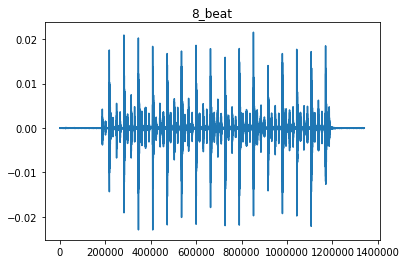

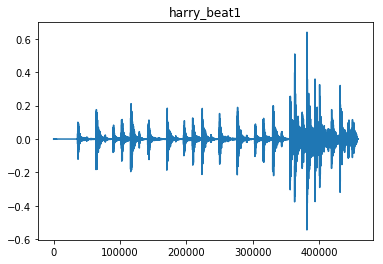

In [5]:
plt.plot(beats[0])
plt.title("8_beat")
plt.show()
plt.plot(beats[1])
plt.title("harry_beat1")
plt.show()

In [6]:
ebns = []
thresholds = []
onsets = []
for b in beats:
    ebn = energy_based_novelty(b, SETTINGS.data["cropped"]["hanning_window_size"])
    threshold = threshold_func(ebn, int(SETTINGS.data["cropped"]["down_sampling_rate"]/5), 3*stats.stdev(ebn.tolist()), 3)
    ebns.append(ebn)
    thresholds.append(threshold)
    onsets.append(onset_detection(ebn, threshold, SETTINGS.data["cropped"]["onset_trim"]))

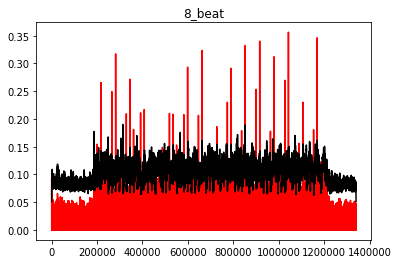

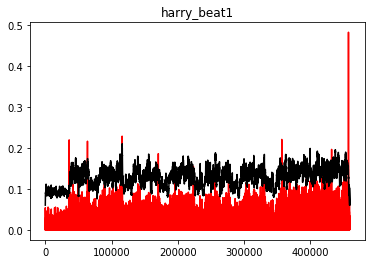

In [7]:
for b in range(2):
    plt.plot(ebns[b], color="red")
    plt.plot(thresholds[b], color="black")
    plt.title(["8_beat", "harry_beat1"][b])
    plt.show()

**Expected: 64 since 8_beat is 8 beats per bar for 8 bars**

In [8]:
print(len(onsets[0]))

60


**Expected: 36 since harry_beat1 is 8 beats per bar for first 3 bars followed by a 12 hit fill**

In [9]:
print(len(onsets[1]))

12


In [10]:
onset_times = onsets[0]/48000
first_time = onset_times[0]
onset_times = onset_times - first_time
onset_times

array([ 0.        ,  0.29333333,  0.636625  ,  1.63108333,  1.97964583,
        2.3180625 ,  2.96008333,  3.29354167,  3.62366667,  4.2679375 ,
        4.60752083,  4.61810417,  4.86827083,  4.93770833,  5.59802083,
        5.93829167,  5.94364583,  6.27035417,  6.91658333,  7.2525    ,
        7.57272917,  8.149625  ,  8.23816667,  8.5828125 ,  8.9175    ,
        9.22633333,  9.57666667,  9.92072917, 10.2656875 , 10.906625  ,
       11.25772917, 11.37425   , 11.58277083, 11.90625   , 12.2288125 ,
       12.5563125 , 12.90683333, 13.53729167, 13.86145833, 14.20916667,
       14.54720833, 14.55427083, 14.87066667, 15.19683333, 15.52529167,
       15.827875  , 15.85752083, 16.18304167, 16.51570833, 16.84852083,
       17.3890625 , 17.50122917, 17.83408333, 18.301375  , 18.81420833,
       19.15264583, 19.82629167, 20.14233333, 20.47702083, 20.8123125 ])

In [41]:
def get_tempo(samples):
    hop_len = 512
    onset_env = onset.onset_strength(y=samples, sr=48000, hop_length=hop_len)
    tempo = beat.tempo(onset_envelope=onset_env, sr=48000, hop_length=hop_len)[0]
    if tempo > 140:
        tempo /= 2
    return tempo

*Finding tempos, so that times of hits can be divided into bars*

In [42]:
tempo0 = get_tempo(beats[0])
tempo1 = get_tempo(beats[1])
print(tempo0, tempo1)

87.890625 108.17307692307692


In [43]:
time_per_measure0 = 60/tempo0*4
time_per_measure1 = 60/tempo1*4
print(time_per_measure0, time_per_measure1)

2.7306666666666666 2.2186666666666666


In [87]:
def predict_notes(beat):
    '''#Find onsets in samples
    ebn = energy_based_novelty(beat, SETTINGS.data["cropped"]["hanning_window_size"])
    threshold = threshold_func(ebn, int(SETTINGS.data["cropped"]["down_sampling_rate"]/5), 3*stats.stdev(ebn.tolist()), 3)
    onsets = onset_detection(ebn, threshold, SETTINGS.data["cropped"]["onset_trim"])
    '''
    ebn=ebns[0]
    threshold=thresholds[0]
    onsets=onset_detection(ebn, threshold, SETTINGS.data["cropped"]["onset_trim"])
    print(onsets)
    
    #Onset times in seconds
    onset_times = onsets/48000
    first_time = onset_times[0]
    onset_times = onset_times - first_time
    
    #Tempo and seconds per bar/measure (assumes 4 beats per bar)
    tempo = get_tempo(beat)
    time_per_measure = 60/tempo*4
    eighth = time_per_measure/8
    
    score = []
    measures = int(np.ceil(onset_times[-1]/time_per_measure))
    for measure_i in range(measures):
        measure = {b: None for b in range(8)}
        measure_start = measure_i*time_per_measure
        measure_end = (measure_i+1)*time_per_measure
        hits = [np.where(onset_times==onset_t)[0][0] for onset_t in onset_times.tolist() if measure_start <= onset_t and measure_end > onset_t]
        for hit_i in hits:
            print(hits,"\n\n", hit_i,"\n\n", beat)
            hit = beat[onsets[hit_i]:onsets[hit_i]+12000]
            # Check and if necessary correct data length
            diff = hit.size - 12000
            if (diff < 0):
                hit = np.pad(hit, (0, abs(diff)), mode="constant")
            elif (diff > 0):
                hit = hit[:-diff]
            pred = True
            #pred = model.predict(hit.reshape(1, 12000, 1))
            #change label into instrument
            onset_time = onset_times[hit_i]
            for position in range(8):
                pos_lower_thr = position*eighth - eighth/2 + measure_start
                pos_upper_thr = position*eighth + eighth/2 + measure_start
                if (pos_lower_thr < onset_time and onset_time <= pos_upper_thr):
                    if (measure[position] is None):
                        measure[position] = pred
                    elif (position < 7):
                        measure[position+1] = pred
        score.append(measure)
    return score

In [89]:
score = predict_notes(beats[0])
n = 0
for m in score:
    n += reduce(lambda acc, x: acc+1 if x is True else acc, m.values(), 0)
print(n)
print(score)

[ 186687  200767  217245  264979  281710  297954  328771  344777  360623
  391548  407848  408356  420364  423697  455392  471725  471982  487664
  518683  534807  550178  577869  582119  598662  614727  629551  646367
  662882  679440  710205  727058  732651  742660  758187  773670  789390
  806215  836477  852037  868727  884953  885292  900479  916135  931901
  946425  947848  963473  979441  995416 1021362 1026746 1042723 1065153
 1089769 1106014 1138349 1153519 1169584 1185678]
[0, 1, 2, 3, 4, 5] 

 0 

 [-1.47892518e-05 -4.89908405e-06  1.72257412e-06 ...  1.32561887e-06
 -7.49194794e-06 -3.80904908e-05]
[0, 1, 2, 3, 4, 5] 

 1 

 [-1.47892518e-05 -4.89908405e-06  1.72257412e-06 ...  1.32561887e-06
 -7.49194794e-06 -3.80904908e-05]
[0, 1, 2, 3, 4, 5] 

 2 

 [-1.47892518e-05 -4.89908405e-06  1.72257412e-06 ...  1.32561887e-06
 -7.49194794e-06 -3.80904908e-05]
[0, 1, 2, 3, 4, 5] 

 3 

 [-1.47892518e-05 -4.89908405e-06  1.72257412e-06 ...  1.32561887e-06
 -7.49194794e-06 -3.809049

In [34]:
transcripts_dir = os.path.join(os.getcwd(), "transcripts")

def transcribe_predictions(filepath, score):
    name = os.path.split(filepath)[-1].split(".")[0]
    measures = []
    for m in range(len(score)):
        notes = score[m]
        content = []
        if (m == 0):
            content.append(measure_attributes)
        cns = []
        dns = []
        for pos in range(8):
            note = notes[pos]
            if (note is not None):
                if (notes[pos] in cymbal_notes):
                    cns.append(instruments[n])
                if (n in drum_notes):
                    dns.append(instruments[n])
        if (len(cns) > 0):
            content.extend(cns)
            if (len(dns) > 0):
                content.append(backup)
        if (len(dns) > 0):
            content.extend(dns)
        if (m == bars - 1):
            content.append(end_line)
        measure = '''
        <measure>
        {}
        </measure>
        '''.format("\n\t".join(content))
        measures.append(measure)
    part = "\n\t".join(measures)
    musicxml = body.format(name, str(datetime.datetime.now().strftime('%d-%m-%Y_%H-%M-%S')), drumkit_part_list, part)

IndentationError: expected an indented block (<ipython-input-34-ea8e38d908c4>, line 14)

In [86]:
a = {3: None}
a[3] is None

True

In [34]:
transcribe_wav("test.wav")